In [1]:
import sys
sys.path.append('..')
from utils_data import read_numbered_dataset_df, get_xy_glue, get_disagree_glue
from tqdm import tqdm
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, torch
from transformer_lens import HookedTransformer
from utils_sae import get_gemma_2_9b_sae_ids_largest_l0s, load_gemma_2_9b_sae

from dotenv import load_dotenv
load_dotenv()
from os import getenv

HF_TOKEN = getenv('HF_TOKEN')
OPENROUTER_KEY = getenv('OPENROUTER_KEY')

plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 6,          # Title size for axes
    'axes.labelsize': 6,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 6,        # Overall figure title size
})

This file plots the GLUE CoLA results. It also has functionality to create the cleaned, ensembled dataset using LLM judges

# Make GLUE CoLA plot

[1, 0.78, 0]


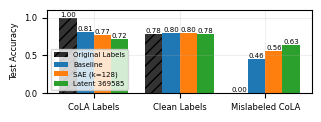

In [3]:
def get_results():
    df = pd.read_csv('../results/investigate/87_glue_cola_investigate_probes.csv')
    return df

def plot_results():
    df = get_results()
    original_labels = [1,1-len(get_disagree_glue('..'))/1000, 0]
    print(original_labels)
    
    # Set up the plot
    plt.figure(figsize=(3.25, 1.2))
    
    # Set width of bars and positions of the bars
    width = 0.2  # Reduced from 0.25 to fit 4 bars
    x = np.arange(3)  # 3 run numbers
    
    # Create bars for each run_type
    baseline_vals = df[df['run_type'] == 'baseline']['test_acc']
    sae128_vals = df[df['run_type'] == 'sae_128']['test_acc']
    sae1_vals = df[df['run_type'] == 'sae_1']['test_acc']
    
    # Plot original labels first
    plt.bar(x - 1.5*width, original_labels, width, label='Original Labels', alpha=0.8, color='black', hatch='///')
    plt.bar(x - 0.5*width, baseline_vals, width, label='Baseline', alpha=1.0)
    plt.bar(x + 0.5*width, sae128_vals, width, label='SAE (k=128)', alpha=1.0)
    plt.bar(x + 1.5*width, sae1_vals, width, label='Latent 369585', alpha=1.0)

    # Add value labels on top of each bar
    for i in range(len(x)):
        plt.text(x[i] - 1.5*width, original_labels[i], f'{original_labels[i]:.2f}',
                ha='center', va='bottom', fontsize=5)
        plt.text(x[i] - 0.5*width, baseline_vals.iloc[i], f'{baseline_vals.iloc[i]:.2f}', 
                ha='center', va='bottom', fontsize=5)
        plt.text(x[i] + 0.5*width, sae128_vals.iloc[i], f'{sae128_vals.iloc[i]:.2f}',
                ha='center', va='bottom', fontsize=5)
        plt.text(x[i] + 1.5*width, sae1_vals.iloc[i], f'{sae1_vals.iloc[i]:.2f}',
                ha='center', va='bottom', fontsize=5)

    # Customize the plot
    plt.ylabel('Test Accuracy')
    plt.xticks(x, ['CoLA Labels', 'Clean Labels', 'Mislabeled CoLA'], fontsize = 6)
    plt.legend(loc = 'lower left', fontsize = 5)
    plt.grid(True, alpha=0.2)
    plt.ylim(0,1.1)

    plt.tight_layout()
    savename = '../figures/investigate/glue_cola_barchart'
    os.makedirs('../figures/investigate', exist_ok=True)
    plt.savefig(f'{savename}.png', dpi = 300)
    plt.savefig(f'{savename}.pdf', dpi = 300)
    plt.show()

plot_results()

# Establish Dataset

Runs prompts on OpenRouter to get a clean label

In [19]:
def fill_str(sentence):
    return f"Task: Determine if the following sentence is grammatical or ungrammatical based on these criteria:\nIt must begin with a capital letter.\nIt must end with proper punctuation (e.g., period, question mark, or exclamation mark).\nIt must be structurally and semantically coherent in standard English, including correct subject verb agreement, parallel structure, and clarity.\nIt must not contain spelling errors.\nSentence: {sentence}\n\nInstructions: Only respond with one word, Grammatical or Ungrammatical."

In [51]:
def answer_prompts(
    df,
):
    prompts = list(df['prompt'])
    target = list(df['target'])
    
    # Build a base System message to instruct the model to act as a translator
    headers = {
    "Authorization": f"Bearer {OPENROUTER_KEY}",
    "Content-Type": "application/json"
    }

    bar = tqdm(prompts)
    models = ["openai/chatgpt-4o-latest", "anthropic/claude-3.5-sonnet","meta-llama/llama-3.1-405b-instruct"]
    
    # Create empty lists to store results
    all_prompts = []
    all_targets = []
    model_answers = {model.split('/')[-1]: [] for model in models}
    
    for i, prompt in enumerate(bar):
        all_prompts.append(prompt)
        all_targets.append(target[i])
        
        for model in models:
            payload = {
                "model": model,
                "messages": [{"role": "user", "content": fill_str(prompt)}],
                "top_p": 1,
                "temperature": 1,
                "frequency_penalty": 0,
                "presence_penalty": 0,
                "repetition_penalty": 1,
                "top_k": 0
            }
            response = requests.post(
                url="https://openrouter.ai/api/v1/chat/completions",
                headers=headers,
                json=payload
            )
        
            answer = response.json()['choices'][0]['message']['content']
            model_answers[model.split('/')[-1]].append(answer)
            
        
        results_df = pd.DataFrame({
            'prompt': all_prompts,
            'original_target': all_targets,
            **model_answers
        })
        
        # Create directory if it doesn't exist
        # Create and save DataFrame after each prompt. after 10 to ensure we don't accidentally overwrite
        if i > 10:
            os.makedirs('data/dataset_investigate', exist_ok=True)
            results_df.to_csv('data/dataset_investigate/87_glue_cola_investigate.csv', index=False)
        bar.set_postfix({k:model_answers[k][-1] for k in model_answers.keys()})

    return results_df

In [2]:
def get_data():
    df = pd.read_csv('results/investigate/87_glue_cola_investigate.csv')
    return df

# Generate activations
For both the base model and SAE

In [ ]:
model_name = 'gemma-2-9b'
device = 'cuda:1'
if model_name == "gemma-2-9b":
    model = HookedTransformer.from_pretrained("google/gemma-2-9b", device=device)
elif model_name == "llama-3.1-8b":
    model = HookedTransformer.from_pretrained("meta-llama/Llama-3.1-8B", device=device)
else:
    raise ValueError(f"Model {model_name} not supported")
os.makedirs(f"data/model_activations_{model_name}_OOD", exist_ok=True)

tokenizer = model.tokenizer
tokenizer.truncation_side='left'
tokenizer.padding_side='right'
if model_name == "gemma-2-9b":
    hook_names = [f"blocks.{layer}.hook_resid_post" for layer in [20]]
elif model_name == "llama-3.1-8b":
    hook_names = ["hook_embed"] + [f"blocks.{layer}.hook_resid_post" for layer in [8, 16, 24, 31]]
else:
    raise ValueError(f"Model {model_name} not supported")

In [ ]:
dataset_names = ['87_glue_cola']
max_seq_len = 1024
with torch.no_grad():
    for dataset_name in tqdm(dataset_names):
        file_names = [f"data/dataset_investigate/{dataset_name}_{hook_name}.pt" for hook_name in hook_names]
        lengths = None
        if all(os.path.exists(file_name) for file_name in file_names):
            lengths = [torch.load(file_name, weights_only=True).shape[0] for file_name in file_names]

        dataset = get_data()
        text = dataset["prompt"].tolist()
        
        text_lengths = []
        for t in text:
            text_lengths.append(len(tokenizer(t)['input_ids']))

        if lengths is not None and all(length == len(text_lengths) for length in lengths):
            print(f"Skipping {dataset_name} because correct length activations already exist")
            continue

        if lengths is not None:
            print(f"Generating activations for {dataset_name} (bad existing activations)")
            print(lengths, len(text_lengths))
        else:
            print(f"Generating activations for {dataset_name} (no existing activations)")


        batch_size = 1
        all_activations = {hook_name: [] for hook_name in hook_names}
        bar = tqdm(range(0, len(text), batch_size))
        for i in bar:
            batch_text = text[i:i+batch_size]
            batch_lengths = text_lengths[i:i+batch_size]
            batch = tokenizer(batch_text, padding=True, truncation=True, max_length=max_seq_len, return_tensors="pt")
            batch = batch.to(device)
            logits, cache = model.run_with_cache(batch["input_ids"], names_filter=hook_names)
            for j, length in enumerate(batch_lengths):
                for hook_name in hook_names:
                    activation_pos = min(length - 1, max_seq_len - 1)
                    all_activations[hook_name].append(cache[hook_name][:, activation_pos].cpu())
            print(i, len(bar))
            del logits, cache
            bar.set_description(f"{len(all_activations[hook_name])}")

        print(i, len(all_activations[hook_name]), len(torch.cat(all_activations[hook_name])))

        for hook_name, file_name in zip(hook_names, file_names):
            all_activations[hook_name] = torch.cat(all_activations[hook_name])
            torch.save(all_activations[hook_name], file_name)

# Generate SAE Activations 

In [2]:
model_name = 'gemma-2-9b'
device = 'cuda:1'
sae_id = get_gemma_2_9b_sae_ids_largest_l0s(layer = 20)[-1]
sae = load_gemma_2_9b_sae(sae_id).to(device)
sae

SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [8]:
def save_activations(path, activation):
    sparse_tensor = activation.to_sparse()
    torch.save(sparse_tensor, path)
    
def save_with_sae(sae):
    datasets =['87_glue_cola']
    with torch.no_grad():
        for dataset in tqdm(datasets):
            path = f"data/dataset_investigate/sae_{model_name}_{dataset}.pt"
            X, _ = get_xy_glue()
            batch_size = 128
            X_sae = []
            for i in range(0, len(X), batch_size):
                batch = X[i:i+batch_size].to(device)
                X_sae.append(sae.encode(batch))
            X_sae = torch.cat(X_sae).cpu()
            print(X_sae.shape)
            save_activations(path, X_sae)

save_with_sae(sae)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.39s/it]

torch.Size([1000, 1048576])
